# 青空文庫の感情分析

以下は，Google Colabで実行されることを想定しています．

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

## データ取得

* 以下のサイトより青空文庫のテキストデータを取得する
  * https://github.com/aozorahack/aozorabunko_text

* 上のサイトの「README.md」より抜粋
  * 青空文庫( https://www.aozora.gr.jp )のサーバ内にある青空文庫形式のテキストのみをテキスト式のまま集めたものです。

In [2]:
!wget https://github.com/aozorahack/aozorabunko_text/archive/master.zip

--2023-05-05 06:03:15--  https://github.com/aozorahack/aozorabunko_text/archive/master.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/aozorahack/aozorabunko_text/zip/refs/heads/master [following]
--2023-05-05 06:03:16--  https://codeload.github.com/aozorahack/aozorabunko_text/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [      <=>           ] 252.57M  6.38MB/s    in 42s     

2023-05-05 06:03:59 (6.04 MB/s) - ‘master.zip’ saved [264836391]



In [3]:
!unzip master.zip

Streaming output truncated to the last 5000 lines.
   creating: aozorabunko_text-master/cards/001585/files/54220_txt_54010/
  inflating: aozorabunko_text-master/cards/001585/files/54220_txt_54010/54220_txt_54010.txt  
   creating: aozorabunko_text-master/cards/001585/files/54221_ruby_54009/
  inflating: aozorabunko_text-master/cards/001585/files/54221_ruby_54009/54221_ruby_54009.txt  
   creating: aozorabunko_text-master/cards/001585/files/54222_txt_54014/
  inflating: aozorabunko_text-master/cards/001585/files/54222_txt_54014/54222_txt_54014.txt  
   creating: aozorabunko_text-master/cards/001585/files/54223_ruby_54015/
  inflating: aozorabunko_text-master/cards/001585/files/54223_ruby_54015/54223_ruby_54015.txt  
   creating: aozorabunko_text-master/cards/001585/files/54224_txt_54149/
  inflating: aozorabunko_text-master/cards/001585/files/54224_txt_54149/54224_txt_54149.txt  
   creating: aozorabunko_text-master/cards/001585/files/54225_txt_54148/
  inflating: aozorabunko_text-maste

In [ ]:
# 必要に応じてフォルダ削除
# !rm -rf bunko

In [4]:
# フォルダ名を変更する
!mv aozorabunko_text-master bunko

In [5]:
CARD_DIR = 'bunko/cards'

In [7]:
# 全てのテキストファイルを files 以下に移動しておく
for author in os.listdir(CARD_DIR):
    for file_path in (glob.glob(f'{CARD_DIR}/{author}/**/*.txt', recursive=True)):
        file = file_path.split('/')[-1]
        target_folder = f'{CARD_DIR}/{author}/files'
        target_path = f'{target_folder}/{file}'
        if os.path.isfile(target_path):
            print(f'file exists: {target_path}')
        else:
            print(f'{file_path} -> {target_path}')
            shutil.move(file_path, target_folder)

Streaming output truncated to the last 5000 lines.
file exists: bunko/cards/001569/files/53222_ruby_49853.txt
file exists: bunko/cards/001569/files/59772_txt_73424.txt
file exists: bunko/cards/001569/files/59219_ruby_76212.txt
file exists: bunko/cards/001569/files/57295_ruby_58705.txt
file exists: bunko/cards/001569/files/59764_txt_75618.txt
file exists: bunko/cards/001569/files/53221_ruby_49863.txt
file exists: bunko/cards/001569/files/59190_ruby_72439.txt
file exists: bunko/cards/001569/files/59813_ruby_75423.txt
file exists: bunko/cards/001569/files/59780_ruby_75639.txt
file exists: bunko/cards/001569/files/57269_ruby_61544.txt
file exists: bunko/cards/001569/files/59194_txt_71260.txt
file exists: bunko/cards/001569/files/57277_ruby_61964.txt
file exists: bunko/cards/001569/files/59602_ruby_73169.txt
file exists: bunko/cards/001569/files/53238_ruby_49809.txt
file exists: bunko/cards/001569/files/59802_ruby_74375.txt
file exists: bunko/cards/001569/files/59189_txt_70939.txt
file exis

## データクレンジング

青空文庫データのクレンジングについては以下のサイトを参考に修正しています．
* [Pythonで青空文庫データを自然言語処理向けにさくっと一括テキスト整形＋前処理](https://qiita.com/dzbt_dzbt/items/593dbd698a07c12a771c)

### クレンジング用関数定義

In [8]:
author_id = '000148'  # 青空文庫の作家番号
author_name = '夏目漱石'  # 青空文庫の表記での作家名

write_title = False # 2カラム目に作品名を入れるか
write_header = True # 1行目をカラム名にするか（カラム名「text」「title」）
save_utf8_org = True  # 元データをUTF-8にしたテキストファイルを保存するか
split_kuten = True # 句点「。」で分割するか

out_dir = Path(f'/content/bunko/cards/{author_id}/files/')  # ファイル出力先
tx_org_dir = Path(out_dir / './org/')  # 元テキストのUTF-8変換ファイルの保存先
tx_edit_dir = Path(out_dir / './edit/')  # テキスト整形後のファイル保存先

In [9]:
# DataFrameで渡されたテキストデータをクレンジングする
def text_cleanse_df(df):
    # 本文の先頭を探す（'---…'区切りの直後から本文が始まる前提）
    head_tx = list(df[df['text'].str.contains(
        '-------------------------------------------------------')].index)
    # 本文の末尾を探す（'底本：'の直前に本文が終わる前提）
    atx = list(df[df['text'].str.contains('底本：')].index)
    if head_tx == []:
        # もし'---…'区切りが無い場合は、作家名の直後に本文が始まる前提
        head_tx = list(df[df['text'].str.contains(author_name)].index)
        head_tx_num = head_tx[0]+1
    else:
        # 2個目の'---…'区切り直後から本文が始まる
        head_tx_num = head_tx[1]+1
    df_e = df[head_tx_num:atx[0]]

    # 句点で分割
    if split_kuten:
        # df.assign(コメント=df['コメント'].str.split(r'(?<=。)(?=..)')).explode('コメント')
        df_e = df_e.assign(text=df['text'].str.split(r'(?<=。)(?=..)')).explode('text')

    # 青空文庫の書式削除
    df_e = df_e.replace({'text': {'《.*?》': ''}}, regex=True)
    df_e = df_e.replace({'text': {'［.*?］': ''}}, regex=True)
    df_e = df_e.replace({'text': {'｜': ''}}, regex=True)

    # 字下げ（行頭の全角スペース）を削除
    df_e = df_e.replace({'text': {'　': ''}}, regex=True)

    # 節区切りを削除
    df_e = df_e.replace({'text': {'^.$': ''}}, regex=True)
    df_e = df_e.replace({'text': {'^―――.*$': ''}}, regex=True)
    df_e = df_e.replace({'text': {'^＊＊＊.*$': ''}}, regex=True)
    df_e = df_e.replace({'text': {'^×××.*$': ''}}, regex=True)

    # 記号、および記号削除によって残ったカッコを削除
    # df_e = df_e.replace({'text': {'―': ''}}, regex=True)
    # df_e = df_e.replace({'text': {'…': ''}}, regex=True)
    # df_e = df_e.replace({'text': {'※': ''}}, regex=True)
    df_e = df_e.replace({'text': {'「」': ''}}, regex=True)

    # 一文字以下で構成されている行を削除
    df_e['length'] = df_e['text'].map(lambda x: len(x))
    df_e = df_e[df_e['length'] > 1]

    # インデックスがずれるので振りなおす
    df_e = df_e.reset_index().drop(['index'], axis=1)

    # 空白行を削除する（念のため）
    df_e = df_e[~(df_e['text'] == '')]

    # インデックスがずれるので振り直し、文字の長さの列を削除する
    df_e = df_e.reset_index().drop(['index', 'length'], axis=1)
    return df_e

In [10]:
# クレンジングされたデータを保存する
def save_cleanse_text(target_file):
    try:
        # ファイルの読み込み
        print(target_file)
        # Pandas DataFrameとして読み込む（cp932で読み込まないと異体字が読めない）
        df_tmp = pd.read_csv(target_file, encoding='cp932', names=['text'])
        # 元データをUTF-8に変換してテキストファイルを保存
        if save_utf8_org:
            out_org_file_nm = Path(target_file.stem + '_org_utf-8.tsv')
            df_tmp.to_csv(Path(tx_org_dir / out_org_file_nm), sep='\t',
                          encoding='utf-8', index=None)
        # テキスト整形
        df_tmp_e = text_cleanse_df(df_tmp)
        if write_title:
            # タイトル列を作る
            df_tmp_e['title'] = df_tmp['text'][0]
        out_edit_file_nm = Path(target_file.stem + '_clns_utf-8.txt')
        df_tmp_e.to_csv(Path(tx_edit_dir / out_edit_file_nm), sep='\t',
                        encoding='utf-8', index=None, header=write_header)
    except:
        print(f'ERROR: {target_file}')

In [11]:
def exec_clensing():
    # zipファイルのリストを作成
    zip_list = list(out_dir.glob('*.txt'))
    # 保存ディレクトリを作成しておく
    tx_edit_dir.mkdir(exist_ok=True, parents=True)
    if save_utf8_org:
        tx_org_dir.mkdir(exist_ok=True, parents=True)

    for target_file in zip_list:
        save_cleanse_text(target_file)

### データクレンジング実行

In [12]:
# データクレンジング実行
exec_clensing()

/content/bunko/cards/000148/files/58842_ruby_76723.txt
ERROR: /content/bunko/cards/000148/files/58842_ruby_76723.txt
/content/bunko/cards/000148/files/4685_ruby_9479.txt
/content/bunko/cards/000148/files/42156_ruby_16023.txt
/content/bunko/cards/000148/files/764_txt.txt
/content/bunko/cards/000148/files/2674_ruby_6327.txt
/content/bunko/cards/000148/files/752_ruby_2438.txt
/content/bunko/cards/000148/files/759_txt.txt
/content/bunko/cards/000148/files/56143_ruby_50824.txt
/content/bunko/cards/000148/files/2370_ruby_2080.txt
/content/bunko/cards/000148/files/1751_ruby_6331.txt
/content/bunko/cards/000148/files/759_ruby_3240.txt
/content/bunko/cards/000148/files/2671_ruby.txt
/content/bunko/cards/000148/files/798_ruby.txt
/content/bunko/cards/000148/files/2679_ruby_6325.txt
/content/bunko/cards/000148/files/2383_ruby_2323.txt
/content/bunko/cards/000148/files/796_ruby.txt
/content/bunko/cards/000148/files/795_ruby.txt
/content/bunko/cards/000148/files/761_ruby_1861.txt
/content/bunko/car

In [29]:
!ls /content/bunko/cards/000148/files/edit/752_ruby*

/content/bunko/cards/000148/files/edit/752_ruby_2438_clns_utf-8.txt


In [30]:
df = pd.read_csv('/content/bunko/cards/000148/files/edit/752_ruby_2438_clns_utf-8.txt')
df

,text
0,親譲りの無鉄砲で小供の時から損ばかりしている。
1,小学校に居る時分学校の二階から飛び降りて一週間ほど腰を抜かした事がある。
2,なぜそんな無闇をしたと聞く人があるかも知れぬ。
3,別段深い理由でもない。
4,新築の二階から首を出していたら、同級生の一人が冗談に、いくら威張っても、そこから飛び降りる事...
...,...
2705,清は玄関付きの家でなくっても至極満足の様子であったが気の毒な事に今年の二月肺炎に罹って死んで...
2706,死ぬ前日おれを呼んで坊っちゃん後生だから清が死んだら、坊っちゃんのお寺へ埋めて下さい。
2707,お墓のなかで坊っちゃんの来るのを楽しみに待っておりますと云った。
2708,だから清の墓は小日向の養源寺にある。


## 感情分析

### 必要なライブラリの取得

In [17]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.1 MB/s eta 0:00:00


In [19]:
!pip install fugashi ipadic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 56.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556721 sha256=41897a11db53bd3a15cf92e6ebc8430f08b97321fccc32fc4e7e536064974324
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

モデルは以下を使用した．
* https://huggingface.co/koheiduck/bert-japanese-finetuned-sentiment

In [21]:
tokenizer = AutoTokenizer.from_pretrained("koheiduck/bert-japanese-finetuned-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("koheiduck/bert-japanese-finetuned-sentiment")

### 感情分析用関数定義

In [22]:
from tqdm import tqdm

In [23]:
# スコア取得関数
def get_score(result):
    if result['label'] == 'POSITIVE':
        return result['score']
    elif result['label'] == 'NEGATIVE':
        return -1 * result['score']
    else:
        return 0

In [24]:
# 指定した作品の感情スコアを取得する関数
def get_sentiment_score(file, debug=False):
    emo_arc = []
    df = pd.read_csv(file)
    for i, text in enumerate(tqdm(df['text'])):
        score = get_score(nlp(text)[0])
        emo_arc.append(score)
        if debug:
            print(f'{i}:{text},{score}')
    return emo_arc

In [25]:
# 指定されたwindowサイズで感情スコアの平均値を取得
def get_score_mean(scores, window=10):
    score_mean = []
    for n in range(len(scores) - window + 1):
        score_mean.append(np.mean(scores[n: window+n]))
    return score_mean

In [26]:
# スコアを0-1に規格化
def score_normalize(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

### 動作確認

In [27]:
from transformers import pipeline

In [28]:
# 動作確認
nlp = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)
print(nlp("私はとっても幸せ"))
print(nlp("私はとっても不幸"))

[{'label': 'POSITIVE', 'score': 0.9896088242530823}]
[{'label': 'NEGATIVE', 'score': 0.9918387532234192}]


### (1). 吾輩は猫である

In [ ]:
df_neko = pd.read_csv('/content/aozora/cards/000148/files/edit/789_ruby_5639_clns_utf-8.txt')
df_neko

,text
0,吾輩は猫である。
1,名前はまだ無い。
2,どこで生れたかとんと見当がつかぬ。
3,何でも薄暗いじめじめした所でニャーニャー泣いていた事だけは記憶している。
4,吾輩はここで始めて人間というものを見た。
...,...
9054,吾輩は死ぬ。
9055,死んでこの太平を得る。
9056,太平は死ななければ得られぬ。
9057,南無阿弥陀仏南無阿弥陀仏。


In [ ]:
neko_score = get_sentiment_score('/content/aozora/cards/000148/files/edit/789_ruby_5639_clns_utf-8.txt')
len(neko_score)

100%|██████████| 9059/9059 [25:57<00:00,  5.82it/s]


9059

window size は先行研究([物語展開を考慮した小説データからの表紙の自動生成](https://db-event.jpn.org/deim2019/post/papers/350.pdf))にならって全体の$1/5$にした．

先行研究では極性辞書を使っているため，全単語の$1/5$としているが，このコードでは文単位で感情スコアを取得しているため，全文の$1/5$としている．

In [ ]:
window_size = int(len(neko_score) / 5)
window_size

1811

In [ ]:
# 上で取得したwindow sizeを使用して平均値を取得
neko_score_mean = get_score_mean(neko_score, window=window_size)
len(neko_score_mean)

7249

In [ ]:
# 0〜1で規格化(-1〜1がいいかもしれない)
neko_score_norm = score_normalize(neko_score_mean)
len(neko_score_norm)

7249

[]

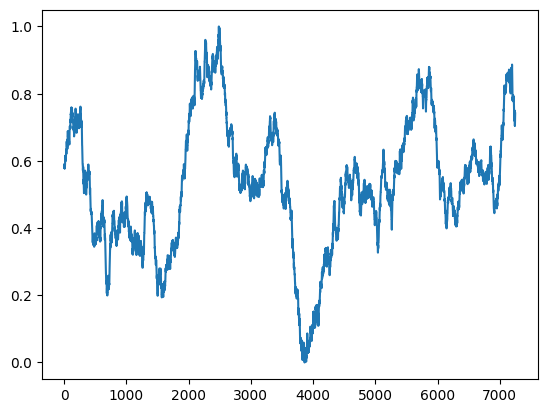

In [ ]:
# 感情曲線の表示
plt.plot(neko_score_norm)
plt.plot()

In [ ]:
# スコア値をテキスト情報に付与
df_neko['score'] = neko_score

In [ ]:
df_neko

,text,score
0,吾輩は猫である。,0.000000
1,名前はまだ無い。,-0.792258
2,どこで生れたかとんと見当がつかぬ。,-0.984861
3,何でも薄暗いじめじめした所でニャーニャー泣いていた事だけは記憶している。,0.000000
4,吾輩はここで始めて人間というものを見た。,0.000000
...,...,...
9054,吾輩は死ぬ。,-0.896015
9055,死んでこの太平を得る。,0.891306
9056,太平は死ななければ得られぬ。,-0.551378
9057,南無阿弥陀仏南無阿弥陀仏。,0.000000


In [ ]:
# csv形式で出力
df_neko.to_csv('neko_score.txt')

In [ ]:
# 確認
df_neko_csv = pd.read_csv('neko_score.txt')

In [ ]:
df_neko_csv

,Unnamed: 0,text,score
0,0,吾輩は猫である。,0.000000
1,1,名前はまだ無い。,-0.792258
2,2,どこで生れたかとんと見当がつかぬ。,-0.984861
3,3,何でも薄暗いじめじめした所でニャーニャー泣いていた事だけは記憶している。,0.000000
4,4,吾輩はここで始めて人間というものを見た。,0.000000
...,...,...,...
9054,9054,吾輩は死ぬ。,-0.896015
9055,9055,死んでこの太平を得る。,0.891306
9056,9056,太平は死ななければ得られぬ。,-0.551378
9057,9057,南無阿弥陀仏南無阿弥陀仏。,0.000000


### (2) 坊ちゃん

In [31]:
df_bochan = pd.read_csv('/content/bunko/cards/000148/files/edit/752_ruby_2438_clns_utf-8.txt')
df_bochan

,text
0,親譲りの無鉄砲で小供の時から損ばかりしている。
1,小学校に居る時分学校の二階から飛び降りて一週間ほど腰を抜かした事がある。
2,なぜそんな無闇をしたと聞く人があるかも知れぬ。
3,別段深い理由でもない。
4,新築の二階から首を出していたら、同級生の一人が冗談に、いくら威張っても、そこから飛び降りる事...
...,...
2705,清は玄関付きの家でなくっても至極満足の様子であったが気の毒な事に今年の二月肺炎に罹って死んで...
2706,死ぬ前日おれを呼んで坊っちゃん後生だから清が死んだら、坊っちゃんのお寺へ埋めて下さい。
2707,お墓のなかで坊っちゃんの来るのを楽しみに待っておりますと云った。
2708,だから清の墓は小日向の養源寺にある。


最後の1行は余分だが，ひとまずこの状態で続行

In [32]:
bochan_score = get_sentiment_score('/content/bunko/cards/000148/files/edit/752_ruby_2438_clns_utf-8.txt')
len(bochan_score)

100%|██████████| 2710/2710 [06:55<00:00,  6.52it/s]


2710

In [35]:
window_size = int(len(bochan_score)/5)
bochan_score_mean = get_score_mean(bochan_score, window=window_size)
len(bochan_score_mean)

2169

In [36]:
bochan_score_norm = score_normalize(bochan_score_mean)
len(bochan_score_norm)

2169

[]

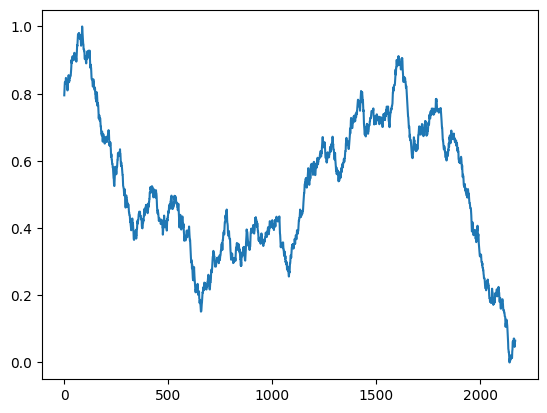

In [37]:
plt.plot(bochan_score_norm)
plt.plot()